[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
### Mount Notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# change the working directory to the Drive root
%cd /content/drive/My\ Drive/Colab\ Notebooks/langchain-academy-main/module-2

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/langchain-academy-main/module-2


In [2]:
!pip install --quiet -U langchain-google-genai langchain_core langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
!pip install --quiet python-dotenv

In [4]:
from dotenv import load_dotenv
load_dotenv(".env")

True

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [7]:
#from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)
#llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='That\'s a great area to research! Beyond the large whales (both baleen and toothed), there\'s a fascinating array of other ocean mammals. Here are some key groups and examples you should definitely learn about:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**\n    *   **Seals (True Seals/Earless Seals):** These are more torpedo-shaped, have no external ear flaps, and use their hind flippers for propulsion in water (they can\'t rotate them forward to "walk" on land, so they undulate their bodies).\n        *   *Examples:* Harbor seals, Grey seals, Harp seals, Ringed seals, Leopard seals, Elephant seals (the largest seals).\n    *   **Sea Lions (Eared Seals):** They have visible external ear flaps and can rotate their hind flippers forward, allowing them to "walk" on all fours on land. They use their powerful front flippers for propulsion in water.\n        *   *Examples:* California sea lions, Steller sea lions, Galapagos sea lions.\n    *   **Walruses:** Distin

We can run our chat model in a simple graph with `MessagesState`.

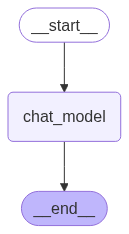

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! Beyond the large whales (both baleen and toothed), there's a fascinating array of other ocean mammals. Here are some key groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    *   **Seals (True Seals/Earless Seals):** These are more torpedo-shaped, have no external ear flaps, and use their hind flippers for propulsion in water (they can't rotate them forward to "walk" on land, so they undulate their bodies).
        *   *Examples:* Harbor seals, Grey seals, Harp seals, Ringed seals, Leopard seals, Elephant seals (the largest

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

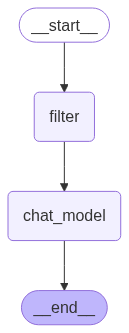

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! Beyond the large whales (both baleen and toothed), there's a fascinating array of other ocean mammals. Here are some key groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    *   **Seals (True Seals/Earless Seals):** These are more torpedo-shaped, have no external ear flaps, and use their hind flippers for propulsion in water (they can't rotate them forward to "walk" on land, so they undulate their bodies).
        *   *Examples:* Harbor seals, Grey seals, Harp seals, Ringed seals, Leopard seals, Elephant seals (the largest

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

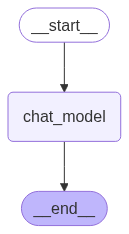

In [12]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! Beyond the large whales (both baleen and toothed), there's a fascinating array of other ocean mammals. Here are some key groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    *   **Seals (True Seals/Earless Seals):** These are more torpedo-shaped, have no external ear flaps, and use their hind flippers for propulsion in water (they c

In [15]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! Beyond the large whales (both baleen and toothed), there's a fascinating array of other ocean mammals. Here are some key groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    *   **Seals (True Seals/Earless Seals):** These are more torpedo-shaped, have no external ear flaps, and use their hind flippers for propulsion in water (they c

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

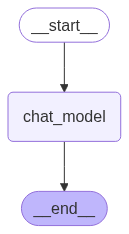

In [16]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            #token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [18]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            #token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [19]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r